## Warning!!! Avert your eyes and proceed to notebooks folder. 

This notebook is just for the developer's reference. It is a stream of thought multivariate analysis so I could design the stats module. Wanted to add it to scripts so that I could reference it if need be. But it is not recommended to use this

In [45]:
from bokeh.plotting import figure, output_file, show
import os 
from bokeh.io import output_notebook
import numpy as np
import pandas as pd
from sqlalchemy import *
output_notebook()
import pickle as pk
from itertools import combinations as comb

from pydoc import help  # can type in the python console `help(name of function)` to get the documentation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from IPython.display import display, HTML

import colcol as c
# figures inline in notebook
%matplotlib inline

np.set_printoptions(suppress=True)

DISPLAY_MAX_ROWS = 20  # number of max rows to print for a DataFrame
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)

Loading BokehJS ...

In [46]:
fs = c.print_filters('wfirst')

In [48]:
dirr = os.getenv('ALBEDO_DB')
engine = create_engine('sqlite:///'+dirr+'AlbedoModels_2015.db')
header = pd.read_sql_table('header',engine)
et= pk.load(open('/Users/natashabatalha/Documents/colorcolor/notebooks/wfirst_colors_dataframe.pk','rb'))#pk.load(open('/Volumes/MyPassportforMac/WFIRST/FluxDataFrameWFIRST.pk','rb'))

In [90]:
et = et.reset_index(drop=True)
everything=et.dropna()[~et.dropna().isin([np.inf, -np.inf])]
everything = everything.dropna()[(everything['cloud']==0) & (everything['phase']==90)]
yofinterest = 'metallicity'

In [92]:
#everything
fcomb = [i[0]+i[1] for i in comb(fs,2)] +list(fs)#independent varianbles 
#fcomb = [i for i in fs]
#fcomb += [ '506', '575', '661', '721', '883', '940']

In [93]:
#corrmat = everything.loc[:,fcomb].corr()
corrmat = everything.loc[(everything['cloud']==0)].corr()

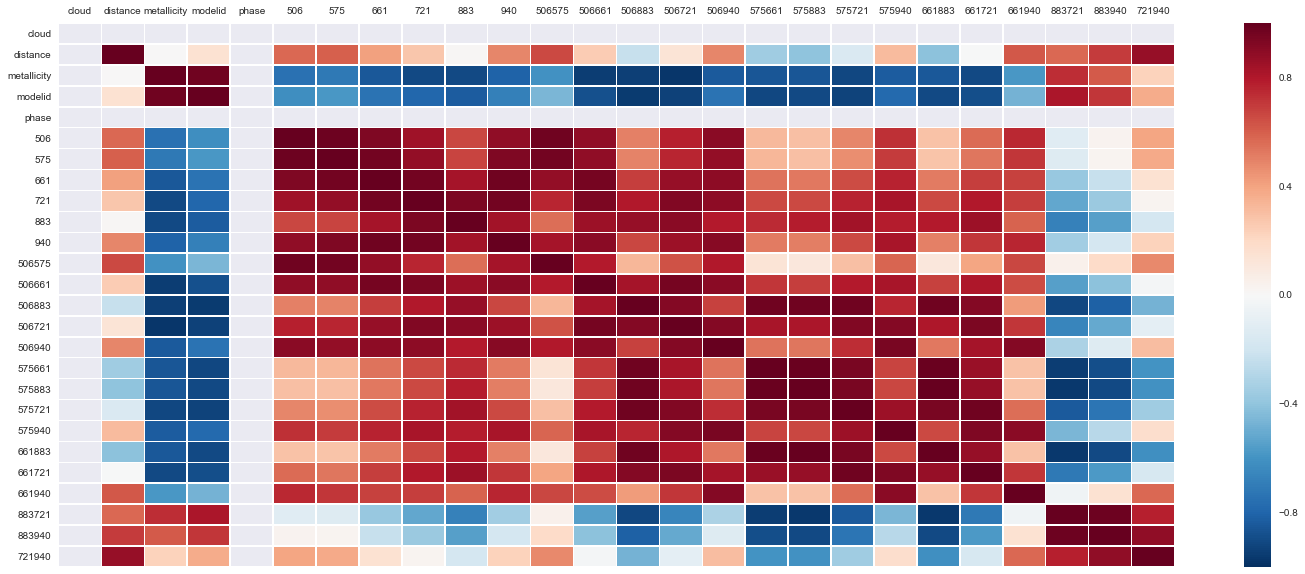

In [94]:
fig, ax = plt.subplots(figsize=(25,10)) 
sns.heatmap(corrmat, vmax=1, square=False, linewidths=.5, ax=ax).xaxis.tick_top()
#.abs()

In [95]:
def mosthighlycorrelated(mydataframe, numtoreport):
    # find the correlations
    cormatrix = mydataframe.corr()
    # set the correlations on the diagonal or lower triangle to zero,
    # so they will not be reported as the highest ones:
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    # find the top n correlations
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    # assign human-friendly names
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    return cormatrix.head(numtoreport)
x = mosthighlycorrelated(everything.loc[:,fcomb].corr(), 10)

In [96]:
x

,FirstVariable,SecondVariable,Correlation
0,575883,661883,0.999982
1,575661,575883,0.999717
2,575661,661883,0.999559
3,506,575,0.998089
4,506883,575721,0.996187
5,506661,721,0.995965
6,883721,883940,0.995917
7,661,940,0.995298
8,661883,883721,-0.994717
9,575883,883721,-0.994519


In [97]:
standardisedX = scale(everything.loc[:,fcomb])
standardisedX = pd.DataFrame(standardisedX, index=everything.loc[:,fcomb].index, columns=everything.loc[:,fcomb].columns)

In [98]:
pca = PCA().fit(standardisedX)

In [99]:
def pca_summary(pca, standardised_data, out=True):
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(np.c_[a, b, c], index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary

In [100]:
summary = pca_summary(pca, standardisedX)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,3.784253e+00,6.819318e-01,0.681932
PC2,2.293602e+00,2.505052e-01,0.932437
PC3,1.014875e+00,4.904627e-02,0.981483
PC4,4.959187e-01,1.171121e-02,0.993194
PC5,3.159447e-01,4.753382e-03,0.997948
PC6,1.533646e-01,1.120033e-03,0.999068
PC7,9.601103e-02,4.389580e-04,0.999507
PC8,7.944826e-02,3.005726e-04,0.999807
PC9,5.976258e-02,1.700746e-04,0.999978


In [101]:
np.sum(summary.sdev**2)

Standard deviation    21.0
dtype: float64

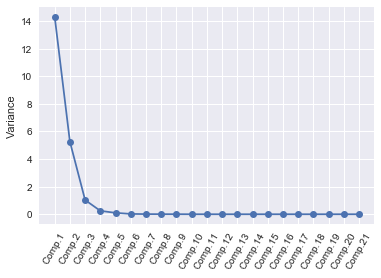

In [102]:
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

screeplot(pca, standardisedX)

In [103]:
summary.sdev**2

,Standard deviation
PC1,1.432057e+01
PC2,5.260609e+00
PC3,1.029972e+00
PC4,2.459353e-01
PC5,9.982103e-02
PC6,2.352069e-02
PC7,9.218118e-03
PC8,6.312026e-03
PC9,3.571566e-03
PC10,3.908067e-04


In [104]:
for i, j in zip(pca.components_[0], fcomb): print( i,j)

0.16706821031116365 506575
0.25276171386370727 506661
0.2446573132905575 506883
0.2626656015911722 506721
0.23790579386243613 506940
0.21939864559663913 575661
0.2185066276952153 575883
0.24362980072232238 575721
0.23888199569155708 575940
0.21759328606573375 661883
0.24630288146455784 661721
0.18208893872045984 661940
-0.18122737823107224 883721
-0.14257914871228522 883940
-0.032145239701775505 721940
0.20304800174263124 506
0.20236471711804538 575
0.23551369667094402 661
0.2457230903808582 883
0.2504437881869244 721
0.2330809351432518 940


In [105]:
def calcpc(variables, loadings):
    # find the number of samples in the data set and the number of variables
    numsamples, numvariables = variables.shape
    # make a vector to store the component
    pc = np.zeros(numsamples)
    # calculate the value of the component for each sample
    for i in range(numsamples):
        valuei = 0
        for j in range(numvariables):
            valueij = variables.iloc[i, j]
            loadingj = loadings[j]
            valuei = valuei + (valueij * loadingj)
        pc[i] = valuei
    return pc

In [106]:
calcpc(standardisedX, pca.components_[0])


array([ 5.79766963,  5.81787919,  5.8775988 ,  5.91308164,  6.03138637,
        6.48917846,  6.78961301,  7.19879981,  7.45495977,  7.63699421,
        2.85282868,  2.69030993,  2.48677807,  2.28734729,  2.23764409,
        2.50277938,  2.94420014,  3.54287301,  3.88703287,  4.09359888,
        0.58740661,  0.09801172, -0.2559384 , -0.65937999, -0.8653655 ,
       -0.72317556, -0.08688654,  0.57059782,  0.93882346,  1.21535137,
       -1.46587507, -1.96999248, -2.46079645, -3.03694573, -3.30849391,
       -3.3143592 , -2.59148797, -1.95354886, -1.47809491, -1.25595012,
       -2.18195253, -2.69569126, -3.20857758, -3.78234084, -4.10466122,
       -4.13832392, -3.4374712 , -2.86698084, -2.34073229, -2.15694168,
       -3.13947379, -3.73542814, -4.15105598, -4.84787641, -5.10356205,
       -5.13411352, -4.51301443, -4.00775682, -3.55623643, -3.41426256])

In [107]:
def pca_scatter(pca, standardised_values, classifs):
    foo = pca.transform(standardised_values)
    bar = pd.DataFrame(list(zip(foo[:, 0], foo[:, 1], classifs)), columns=["PC1", "PC2", "Class"])
    sns.lmplot("PC1", "PC2", bar, hue="Class", fit_reg=False)

In [108]:
X = everything.loc[:,fcomb]
y =  everything[yofinterest].astype(str)
#newy = []
#for i in y: 
#    if float(i) >= 1.7: newy+=['3']
#    elif float(i) <= 0.5: newy+=['1']
#    else: newy +=['2']


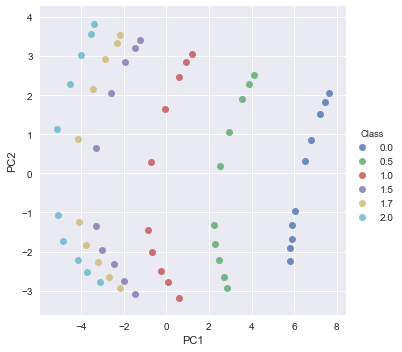

In [109]:
pca_scatter(pca, standardisedX, y)

In [110]:
#classifier so needs to be string.. 
lda = LinearDiscriminantAnalysis().fit(X,y)

In [111]:
def pretty_scalings(lda, X, out=False):
    ret = pd.DataFrame(lda.scalings_, index=X.columns, columns=["LD"+str(i+1) for i in range(lda.scalings_.shape[1])])
    if out:
        print("Coefficients of linear discriminants:")
        display(ret)
    return ret

pretty_scalings_ = pretty_scalings(lda, X, out=True)

Coefficients of linear discriminants:


,LD1,LD2,LD3,LD4,LD5
506575,-4.867797,-11.679734,4.279062,1.994625,-4.385069
506661,7.995204,-2.016834,-2.367462,16.541155,18.590635
506883,-5.114494,-7.866736,-0.769380,0.288328,-0.397665
506721,-10.125185,-8.658974,-0.186921,-2.264751,-11.746275
506940,1.602181,-2.084767,2.713126,2.677695,2.520412
575661,22.842153,35.126199,-15.752786,9.037169,31.149043
575883,-1.591218,-1.907441,-0.884907,-0.131885,0.392389
575721,0.317405,7.330571,-4.097040,-2.824682,-0.817013
575940,5.748547,2.897920,2.520371,3.771360,7.157769
661883,-3.899299,-5.161498,-0.378040,-0.772682,-1.352757


In [112]:
pretty_scalings_.LD1

506575    -4.867797
506661     7.995204
506883    -5.114494
506721   -10.125185
506940     1.602181
575661    22.842153
575883    -1.591218
575721     0.317405
575940     5.748547
661883    -3.899299
            ...    
661940     1.238926
883721     3.059792
883940     2.080374
721940     5.757735
506       -0.000013
575        0.000016
661       -0.000025
883       -0.000807
721        0.000256
940       -0.000661
Name: LD1, Length: 21, dtype: float64

In [113]:
def calcWithinGroupsVariance(variable, groupvariable):
    # find out how many values the group variable can take
    levels = sorted(set(groupvariable))
    numlevels = len(levels)
    # get the mean and standard deviation for each group:
    numtotal = 0
    denomtotal = 0
    for leveli in levels:
        levelidata = variable[groupvariable==leveli]
        levelilength = len(levelidata)
        # get the standard deviation for group i:
        sdi = np.std(levelidata)
        numi = (levelilength)*sdi**2
        denomi = levelilength
        numtotal = numtotal + numi
        denomtotal = denomtotal + denomi
    # calculate the within-groups variance
    Vw = numtotal / (denomtotal - numlevels)
    return Vw
def calcBetweenGroupsVariance(variable, groupvariable):
    # find out how many values the group variable can take
    levels = sorted(set((groupvariable)))
    numlevels = len(levels)
    # calculate the overall grand mean:
    grandmean = np.mean(variable)
    # get the mean and standard deviation for each group:
    numtotal = 0
    denomtotal = 0
    for leveli in levels:
        levelidata = variable[groupvariable==leveli]
        levelilength = len(levelidata)
        # get the mean and standard deviation for group i:
        meani = np.mean(levelidata)
        sdi = np.std(levelidata)
        numi = levelilength * ((meani - grandmean)**2)
        denomi = levelilength
        numtotal = numtotal + numi
        denomtotal = denomtotal + denomi
    # calculate the between-groups variance
    Vb = numtotal / (numlevels - 1)
    return(Vb)
def calclda(variables, loadings):
    # find the number of samples in the data set and the number of variables
    numsamples, numvariables = variables.shape
    # make a vector to store the discriminant function
    ld = np.zeros(numsamples)
    # calculate the value of the discriminant function for each sample
    for i in range(numsamples):
        valuei = 0
        for j in range(numvariables):
            valueij = variables.iloc[i, j]
            loadingj = loadings[j]
            valuei = valuei + (valueij * loadingj)
        ld[i] = valuei
    # standardise the discriminant function so that its mean value is 0:
    ld = scale(ld, with_std=False)
    return ld
def groupStandardise(variables, groupvariable):
    # find the number of samples in the data set and the number of variables
    numsamples, numvariables = variables.shape
    # find the variable names
    variablenames = variables.columns
    # calculate the group-standardised version of each variable
    variables_new = pd.DataFrame()
    for i in range(numvariables):
        variable_name = variablenames[i]
        variablei = variables[variable_name]
        variablei_Vw = calcWithinGroupsVariance(variablei, groupvariable)
        variablei_mean = np.mean(variablei)
        variablei_new = (variablei - variablei_mean)/(np.sqrt(variablei_Vw))
        variables_new[variable_name] = variablei_new
    return variables_new
def calcSeparations(variables, groupvariable):
    # calculate the separation for each variable
    for variablename in variables:
        variablei = variables[variablename]
        Vw = calcWithinGroupsVariance(variablei, groupvariable)
        Vb = calcBetweenGroupsVariance(variablei, groupvariable)
        sep = Vb/Vw
        print("variable", variablename, "Vw=", Vw, "Vb=", Vb, "separation=", sep)

In [114]:
print(calclda(X, lda.scalings_[:, 0]))
print(lda.fit_transform(X, y)[:, 0])

[-83.25339369 -85.29006091 -86.9894682  -86.7546144  -86.03216518
 -85.21617226 -86.94598279 -83.73751083 -85.65701989 -88.47300316
 -28.48061152 -30.00780607 -29.74475158 -28.65041594 -28.00300423
 -28.03566968 -28.40632231 -26.90036305 -26.98027249 -28.59545514
   6.43621666   4.71078412   4.34915824   4.84041968   5.11914704
   3.82413405   4.57687052   6.4365424    5.33186818   3.88687444
  28.42658274  29.19248566  28.41299521  28.24932917  28.92795573
  27.57324786  28.36587631  29.2446758   27.5694452   26.75881318
  34.63785677  36.16530721  36.3518179   35.35074941  35.95848961
  35.80225752  35.88284888  36.65808131  34.97747599  34.3709592
  43.67363625  45.60351101  45.35110023  44.85487686  46.12478459
  45.76202115  45.55595272  46.11833118  45.36686835  45.353715  ]
[-83.25339369 -85.29006091 -86.9894682  -86.7546144  -86.03216518
 -85.21617226 -86.94598279 -83.73751083 -85.65701989 -88.47300316
 -28.48061152 -30.00780607 -29.74475158 -28.65041594 -28.00300423
 -28.03566

In [115]:
groupstandardisedX = groupStandardise(X, y)

In [116]:
y

142     0.0
294     0.0
446     0.0
598     0.0
750     0.0
902     0.0
1054    0.0
1206    0.0
1358    0.0
1510    0.0
       ... 
7742    2.0
7894    2.0
8046    2.0
8198    2.0
8350    2.0
8502    2.0
8654    2.0
8806    2.0
8958    2.0
9110    2.0
Name: metallicity, Length: 60, dtype: object

In [117]:
lda2 = LinearDiscriminantAnalysis().fit(groupstandardisedX, y)
pretty_scalings(lda2, groupstandardisedX)

,LD1,LD2,LD3,LD4,LD5
506575,-1.065737,-2.557117,0.936842,0.436696,-0.960050
506661,0.947595,-0.239036,-0.280593,1.960465,2.203370
506883,-2.054667,-3.160337,-0.309086,0.115831,-0.159756
506721,-1.482720,-1.268010,-0.027372,-0.331647,-1.720111
506940,0.626468,-0.815163,1.060857,1.047004,0.985505
575661,2.809824,4.320890,-1.937758,1.111666,3.831658
575883,-0.970651,-1.163549,-0.539797,-0.080450,0.239359
575721,0.071709,1.656141,-0.925613,-0.638159,-0.184582
575940,1.658141,0.835891,0.726989,1.087831,2.064625
661883,-1.912205,-2.531184,-0.185390,-0.378921,-0.663388


In [118]:
lda.fit_transform(X, y)[:, 0]

array([-83.25339369, -85.29006091, -86.9894682 , -86.7546144 ,
       -86.03216518, -85.21617226, -86.94598279, -83.73751083,
       -85.65701989, -88.47300316, -28.48061152, -30.00780607,
       -29.74475158, -28.65041594, -28.00300423, -28.03566968,
       -28.40632231, -26.90036305, -26.98027249, -28.59545514,
         6.43621666,   4.71078412,   4.34915824,   4.84041968,
         5.11914704,   3.82413405,   4.57687052,   6.4365424 ,
         5.33186818,   3.88687444,  28.42658274,  29.19248566,
        28.41299521,  28.24932917,  28.92795573,  27.57324786,
        28.36587631,  29.2446758 ,  27.5694452 ,  26.75881318,
        34.63785677,  36.16530721,  36.3518179 ,  35.35074941,
        35.95848961,  35.80225752,  35.88284888,  36.65808131,
        34.97747599,  34.3709592 ,  43.67363625,  45.60351101,
        45.35110023,  44.85487686,  46.12478459,  45.76202115,
        45.55595272,  46.11833118,  45.36686835,  45.353715  ])

In [119]:
lda2.fit_transform(groupstandardisedX, y)[:, 0]

array([-83.25339369, -85.29006091, -86.9894682 , -86.7546144 ,
       -86.03216518, -85.21617226, -86.94598279, -83.73751083,
       -85.65701989, -88.47300316, -28.48061152, -30.00780607,
       -29.74475158, -28.65041594, -28.00300423, -28.03566968,
       -28.40632231, -26.90036305, -26.98027249, -28.59545514,
         6.43621666,   4.71078412,   4.34915824,   4.84041968,
         5.11914704,   3.82413405,   4.57687052,   6.4365424 ,
         5.33186818,   3.88687444,  28.42658274,  29.19248566,
        28.41299521,  28.24932917,  28.92795573,  27.57324786,
        28.36587631,  29.2446758 ,  27.5694452 ,  26.75881318,
        34.63785677,  36.16530721,  36.3518179 ,  35.35074941,
        35.95848961,  35.80225752,  35.88284888,  36.65808131,
        34.97747599,  34.3709592 ,  43.67363625,  45.60351101,
        45.35110023,  44.85487686,  46.12478459,  45.76202115,
        45.55595272,  46.11833118,  45.36686835,  45.353715  ])

In [132]:
def rpredict(lda, X, y, out=False):
    ret = {"class": lda.predict(X),
           "posterior": pd.DataFrame(lda.predict_proba(X), columns=lda.classes_)}
    ret["x"] = pd.DataFrame(lda.fit_transform(X, y))
    ret["x"].columns = ["LD"+str(i+1) for i in range(ret["x"].shape[1])]
    #if out:
    #    print("class")
    #    print(ret['class'])# : print(i)
    #    print()
    #    print("posterior")
    #    print(ret["posterior"])
    #    print()
    #    print("x")
    #    print(ret["x"])
    return ret

lda_values = rpredict(lda2, standardisedX.reset_index(drop=True), y.reset_index(drop=True), True)

In [133]:
calcSeparations(lda_values["x"], y.reset_index(drop=True))

variable LD1 Vw= 1.0000000000000062 Vb= 24648.821586327736 separation= 24648.821586327584
variable LD2 Vw= 0.9999999999999964 Vb= 1655.838211318835 separation= 1655.8382113188409
variable LD3 Vw= 0.9999999999999984 Vb= 19.029855202204242 separation= 19.02985520220427
variable LD4 Vw= 1.0000000000000009 Vb= 0.30476620291778234 separation= 0.30476620291778206
variable LD5 Vw= 1.0000000000000038 Vb= 0.22433983476921146 separation= 0.2243398347692106


In [134]:
def ldahist(data, g, sep=False):
    xmin = np.trunc(np.min(data)) - 1
    xmax = np.trunc(np.max(data)) + 1
    ncol = len(set(g))
    print (ncol)
    binwidth = 0.5
    bins=np.arange(xmin, xmax + binwidth, binwidth)
    if sep:
        fig, axl = plt.subplots(ncol, 1, sharey=True, sharex=True)
    else:
        fig, axl = plt.subplots(1, 1, sharey=True, sharex=True)
        axl = [axl]*ncol
    for ax, (group, gdata) in zip(axl, data.groupby(g)):
        sns.distplot(gdata.values, bins, ax=ax, label="group "+str(group))
        ax.set_xlim([xmin, xmax])
        if sep:
            ax.set_xlabel("group"+str(group))
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

6


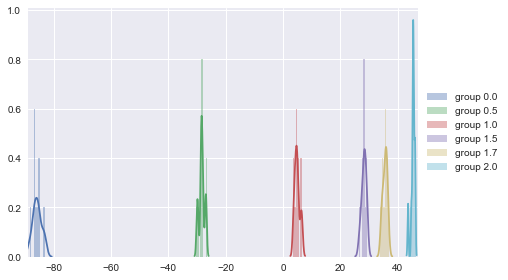

In [135]:
ldahist(lda_values["x"].LD1, y.reset_index(drop=True))

6


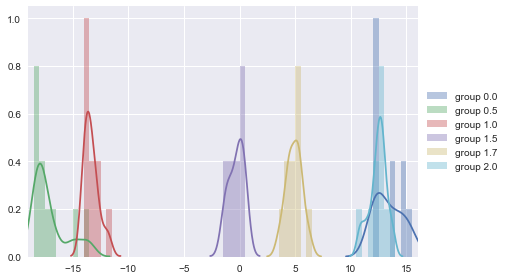

In [136]:
ldahist(lda_values["x"].LD2, y.reset_index(drop=True))

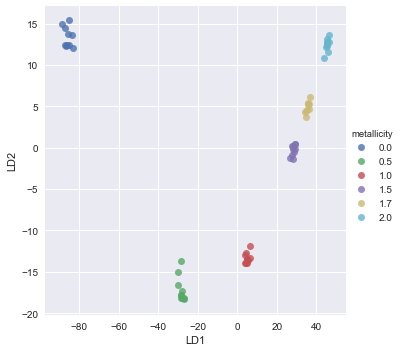

In [125]:
sns.lmplot("LD1", "LD2", lda_values["x"].join(y.reset_index(drop=True)), hue=yofinterest, fit_reg=False);

In [126]:
def printMeanAndSdByGroup(variables, groupvariable):
    data_groupby = variables.groupby(groupvariable)
    print("## Means:")
    display(data_groupby.apply(np.mean))
    print("\n## Standard deviations:")
    display(data_groupby.apply(np.std))
    print("\n## Sample sizes:")
    display(pd.DataFrame(data_groupby.apply(len)))
    return data_groupby.apply(np.mean)
means = printMeanAndSdByGroup(lda_values["x"], y.reset_index(drop=True))

## Means:


,LD1,LD2,LD3,LD4,LD5
metallicity,,,,,
0.0,-85.834939,13.389399,-0.396271,0.015943,-0.009562
0.5,-28.380467,-17.088310,1.738276,-0.098531,0.061757
1.0,4.951202,-13.337375,-1.194347,0.197763,-0.153445
1.5,28.272141,-0.299275,-1.379751,-0.008315,0.252378
1.7,35.615584,4.899704,-0.443928,-0.274260,-0.144863
2.0,45.376480,12.435857,1.676021,0.167399,-0.006263



## Standard deviations:


,LD1,LD2,LD3,LD4,LD5
metallicity,,,,,
0.0,1.489511,1.173490,1.167217,1.047293,1.473887
0.5,0.951415,1.493379,0.703862,0.851007,0.968549
1.0,0.869503,0.615987,0.932036,0.880707,0.793394
1.5,0.744872,0.633038,0.750655,0.733955,0.503239
1.7,0.716747,0.664701,0.518899,0.825918,0.718095
2.0,0.671990,0.755471,1.356744,1.257970,0.944027



## Sample sizes:


,0
metallicity,
0.0,10
0.5,10
1.0,10
1.5,10
1.7,10
2.0,10


In [127]:
import sklearn.metrics as metrics

In [128]:
cutoffs = []
for i in range(len(means['LD1'])): 
    cutoffs +=[np.mean(means['LD1'][i:i+2])]
cutoffs = cutoffs[:-1]
print(cutoffs)

[-57.10770316543061, -11.714632834321625, 16.611671109419266, 31.943862532197414, 40.49603205601133]


In [129]:
def lda_classify(v, levels, cutoffpoints):
    for level, cutoff in zip(reversed(levels), reversed(cutoffpoints)):
        if v > cutoff: return level
    return levels[0]
    
y_pred = lda_values["x"].iloc[:, 0].apply(lda_classify, args=(lda.classes_, cutoffs,)).values
y_true = y.reset_index(drop=True)

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        10
        0.5       1.00      1.00      1.00        10
        1.0       1.00      1.00      1.00        10
        1.5       1.00      1.00      1.00        10
        1.7       1.00      1.00      1.00        10
        2.0       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        60



,Allocated to group 0.0,Allocated to group 0.5,Allocated to group 1.0,Allocated to group 1.5,Allocated to group 1.7,Allocated to group 2.0
Is group 0.0,10,0,0,0,0,0
Is group 0.5,0,10,0,0,0,0
Is group 1.0,0,0,10,0,0,0
Is group 1.5,0,0,0,10,0,0
Is group 1.7,0,0,0,0,10,0
Is group 2.0,0,0,0,0,0,10


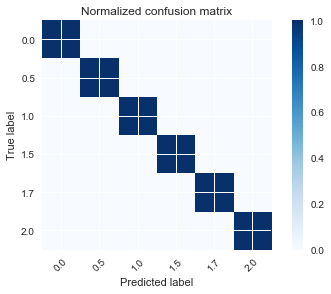

In [130]:
def webprint_confusion_matrix(confusion_matrix, classes_names):
    display(pd.DataFrame(confusion_matrix, index=["Is group "+i for i in classes_names], columns=["Allocated to group "+i for i in classes_names]))

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print(metrics.classification_report(y_true, y_pred))
cm = metrics.confusion_matrix(y_true, y_pred)
webprint_confusion_matrix(cm, lda.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, lda.classes_, title='Normalized confusion matrix')

In [131]:
everything.loc[:,fcomb].values.shape

(60, 21)